In [21]:
import os
import time
import copy
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, BatchNorm1d
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

In [22]:
class Classifier(Module):
    def __init__(self, input_size=(3, 32, 32), output_class=2):
        super(Classifier, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            # taking input size 32 as an example: 3*32*32 --> 16*32*32
            Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(16),
            # taking input size 32 as an example: 16*32*32 --> 16*32*32
            Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(16),
            # taking input size 32 as an example: 16*16*16 --> 16*16*16
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.25),

            # Defining another 2D convolution layer
            # taking input size 32 as an example: 16*16*16 --> 32*16*16
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(32),
            # taking input size 32 as an example: 32*16*16 --> 32*16*16
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(32),
            # taking input size 32 as an example: 32*16*16 --> 32*8*8
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.5)
        )
        n_size = int(np.floor(32*(input_size[1]/4)**2))
        self.linear_layers = Sequential(
            Linear(n_size, 64),
            ReLU(inplace=True),
            BatchNorm1d(64),
            Dropout(0.5),
            Linear(64, output_class),
            Softmax()
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [23]:
data_transforms = {
    'train':
        transforms.Compose([
            transforms.RandomResizedCrop(size=36, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=32),
            transforms.ToTensor(),
            # transforms.Normalize([0.578, 0.468, 0.429],
            #                      [0.257, 0.243, 0.246])
            #transforms.Normalize([0.574, 0.462, 0.421],
            #                    [0.259, 0.244, 0.246])
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])  # Imagenet standards
        ]),
    'val': transforms.Compose([
        transforms.Resize(36),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        # transforms.Normalize([0.578, 0.468, 0.429],
        #                     [0.257, 0.243, 0.246])
        #transforms.Normalize([0.574, 0.462, 0.421],
        #                        [0.259, 0.244, 0.246])
        transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
}

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
data_dir = '.\maskdetection'

In [26]:
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(datasets[x], batch_size=6, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

class_names = datasets['train'].classes

In [27]:
model = Classifier(input_size=(3, 32, 32), output_class=len(class_names))
model.to(device)

Classifier(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [28]:
criterion = nn.CrossEntropyLoss()

In [96]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

In [97]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

In [98]:
model.train()

Classifier(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [99]:
loss_plt = []
acc_plt = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    running_loss, running_loss_val = 0.0, 0.0
    running_corrects, running_corrects_val = 0, 0

    # Iterate over data.
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))

    model.eval()
    for inputs_val, labels_val in dataloaders['val']:
        inputs_val = inputs_val.to(device)
        labels_val = labels_val.to(device)
        with torch.no_grad():
            outputs_val = model(inputs_val)
            _, preds_val = torch.max(outputs_val, 1)
            loss_val = criterion(outputs_val, labels_val)

        # statistics
        running_loss_val += loss_val.item() * inputs_val.size(0)
        running_corrects_val += torch.sum(preds_val == labels_val.data)
    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.double() / dataset_sizes['val']
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', epoch_loss_val, epoch_acc_val))
    loss_plt.append(epoch_loss_val)
    acc_plt.append(epoch_acc_val)
    model.train()

    # deep copy the model
    if epoch_acc_val > best_acc:
        best_acc = epoch_acc_val
        best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/25
----------


C:\Users\shank\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 0.4374 Acc: 0.8740
val Loss: 0.4171 Acc: 0.8939
Epoch 2/25
----------
train Loss: 0.4386 Acc: 0.8723
val Loss: 0.4324 Acc: 0.8798
Epoch 3/25
----------
train Loss: 0.4338 Acc: 0.8770
val Loss: 0.4220 Acc: 0.8891
Epoch 4/25
----------
train Loss: 0.4320 Acc: 0.8790
val Loss: 0.4167 Acc: 0.8934
Epoch 5/25
----------
train Loss: 0.4286 Acc: 0.8829
val Loss: 0.4168 Acc: 0.8929
Epoch 6/25
----------
train Loss: 0.4304 Acc: 0.8800
val Loss: 0.4188 Acc: 0.8920
Epoch 7/25
----------
train Loss: 0.4329 Acc: 0.8794
val Loss: 0.4168 Acc: 0.8929
Epoch 8/25
----------
train Loss: 0.4317 Acc: 0.8788
val Loss: 0.4184 Acc: 0.8918
Epoch 9/25
----------
train Loss: 0.4328 Acc: 0.8780
val Loss: 0.4159 Acc: 0.8946
Epoch 10/25
----------
train Loss: 0.4390 Acc: 0.8718
val Loss: 0.4153 Acc: 0.8958
Epoch 11/25
----------
train Loss: 0.4370 Acc: 0.8742
val Loss: 0.4255 Acc: 0.8860
Epoch 12/25
----------
train Loss: 0.4363 Acc: 0.8740
val Loss: 0.4105 Acc: 0.9010
Epoch 13/25
----------
train Loss: 

In [55]:
import matplotlib.pyplot as plt 
%matplotlib inline

Text(0.5, 1.0, 'Loss vs. No. of epochs for LR = 0.001')

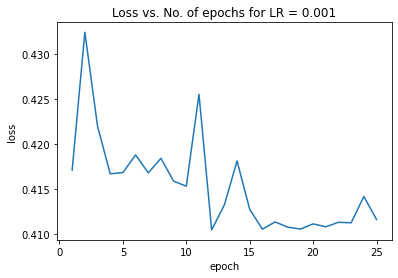

In [100]:
x = np.arange(1, num_epochs+1, 1)
y = loss_plt
plt.plot(x,y)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs for LR = 0.001')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs for LR = 0.001')

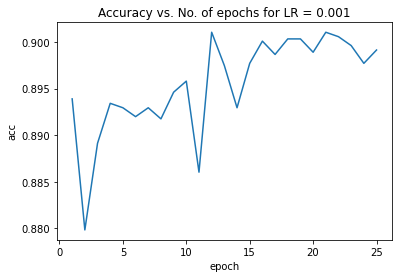

In [101]:
x = np.arange(1, num_epochs+1, 1)
y = acc_plt
plt.plot(x,y)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Accuracy vs. No. of epochs for LR = 0.001')

In [ ]:
from IPython.display import Image 

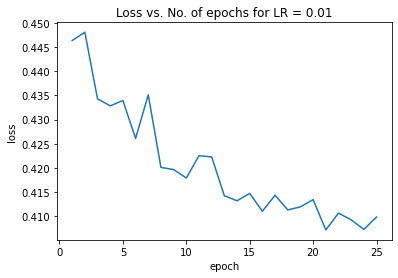

In [95]:
"""
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

Training complete in 10m 2s
Best val Acc: 0.903910
"""

Image(filename = "loss_0.01.png", width = 600, height = 300)

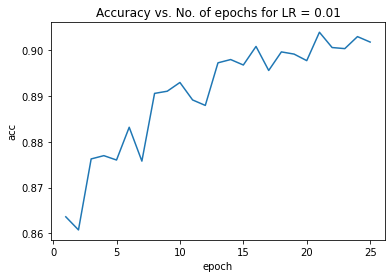

In [94]:
Image(filename = "acc_0.01.png", width = 600, height = 300)

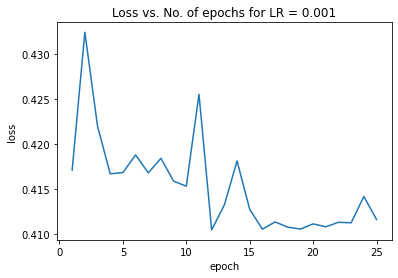

In [106]:
"""
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

Training complete in 10m 13s
Best val Acc: 0.901049
"""

Image(filename = "acc_0.001.png", width = 600, height = 300)

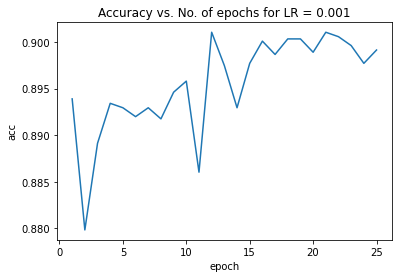

In [107]:
Image(filename = "loss_0.001.png", width = 600, height = 300)

In [108]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [109]:
torch.save(model.state_dict(), 'float32_maskmodel.pth')